# Bring your own data to create a music genre model for AWS DeepComposer

---

This notebook is for the <b>Bring your own data to create a music genre model for AWS DeepComposer</b> blog and is associated with the <b> AWS DeepComposer: Train it Again Maestro </b> web series on the <b>A Cloud Guru</b> platform.
     
This covers preparing your data to train a custom music genre model for AWS DeepComposer.
  
---

In [1]:
# Create the environment
!conda update --all --y 
!pip install numpy==1.16.4
!pip install pretty_midi
!pip install pypianoroll

Solving environment: \ 
  - defaults::astroid-2.3.3-py36_0, defaults::path-13.2.0-py36_0, defaults::path.py-12.0.2-py_0, defaults::wrapt-1.12.1-py36h7b6447c_1
  - defaults::astroid-2.3.3-py36_0, defaults::path-13.1.0-py36_0, defaults::path.py-12.4.0-0, defaults::wrapt-1.12.1-py36h7b6447c_1
  - defaults::astroid-2.4.0-py36_0, defaults::path-13.1.0-py36_0, defaults::path.py-12.4.0-0, defaults::wrapt-1.11.2-py36h7b6447c_0
  - defaults::astroid-2.4.0-py36_0, defaults::path-13.2.0-py36_0, defaults::path.py-12.0.2-py_0, defaults::wrapt-1.11.2-py36h7b6447cdone


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    immutables-0.11          

In [20]:
# IMPORTS
import os 
import numpy as np
from numpy import save
import pypianoroll
from pypianoroll import Multitrack, Track

from utils import display_utils

import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
root_dir = './2Experiments'

# Directory to save checkpoints
model_dir = os.path.join(root_dir,'2Reggae')    # JSP: 229, Bach: 19199

# Directory to save pianorolls during training
train_dir = os.path.join(model_dir, 'train')

# Location of the original MIDI files used for training; place your MIDI files here 
reggae_midi_location = './reggae_midi/'

# Prepare Training Data (MIDI files ----->  .npy)

---

This section of code demonstrates the process of converting MIDI files to the needed format for training, which is a .npy file.

---

In [22]:
#helper function that stores the reshaped arrays, per instrument

def store_track(track, collection):
    """
    Pull out the 4 selected instrument types based on program number 
    The program number represents the unique identifier for the instrument (ie. track.program)
    https://en.wikipedia.org/wiki/General_MIDI
    """
    
    instrument1_program_numbers = [1,2,3,4,5,6,7,8] #Piano
    instrument2_program_numbers = [17,18,19,20,21,22,23,24] #Organ
    instrument3_program_numbers = [33,34,35,36,37,38,39,40] #Bass
    instrument4_program_numbers = [25,26,27,28,29,30,31,32] #Guitar
    
    if isinstance (collection, dict): 
        if track.program in instrument1_program_numbers: 
            collection['Piano'].append(track)
        elif track.program in instrument2_program_numbers:
            collection['Organ'].append(track)
        elif track.program in instrument3_program_numbers:
            collection['Bass'].append(track)
        elif track.program in instrument4_program_numbers:
            collection['Guitar'].append(track)
        else:
            print("Skipping this instrument------------------->", track.name)
    else: #collection will hold chosen tracks
        if track.program in instrument1_program_numbers: 
            collection.append(track)
        elif track.program in instrument2_program_numbers:
            collection.append(track)
        elif track.program in instrument3_program_numbers:
            collection.append(track)
        elif track.program in instrument4_program_numbers:
            collection.append(track)
        else:
            print("Skipping this instrument------------------->", track.name)
    
    return collection

In [23]:
#helper function that returns the pianorolls merged to 4 tracks for 4 chosen instruments

def get_merged(music_tracks, filename):
    
    chosen_tracks = [] 
    
    #choose the tracks from the Multitrack object
    for index, track in enumerate(music_tracks.tracks): 
        chosen_tracks = store_track(track, chosen_tracks)
    
    #dictionary to hold reshaped pianorolls for 4 chosen instruments  
    reshaped_piano_roll_dict = {'Piano': [], 'Organ': [], 'Bass': [], 'Guitar': []}  
    
    #loop thru chosen tracks
    for index, track in enumerate(chosen_tracks): 
        fig, ax = track.plot()
        plt.show()
        
        try:
            #reshape pianoroll to 2 bar (i.e. 32 time step) chunks  
            track.pianoroll = track.pianoroll.reshape( -1, 32, 128)
            
            #store reshaped pianoroll per instrument
            reshaped_piano_roll_dict = store_track(track, reshaped_piano_roll_dict)     
        except Exception as e: 
            print("ERROR!!!!!----> Skipping track # ", index, " with error ", e)
        
    #will hold all merged instrument tracks 
    merge_piano_roll_list = []
    
    for instrument in reshaped_piano_roll_dict: 
        try:
            merged_pianorolls = np.empty(shape=(0,32,128))

            #concatenate/stack all tracks for a single instrument
            if len(reshaped_piano_roll_dict[instrument]) > 0:
                if reshaped_piano_roll_dict[instrument]:     
                    merged_pianorolls = np.stack([track.pianoroll for track in reshaped_piano_roll_dict[instrument]], -1)
                    
                merged_pianorolls = merged_pianorolls[:, :, :, 0] 
                merged_piano_rolls = np.any(merged_pianorolls, axis=0)
                merge_piano_roll_list.append(merged_piano_rolls)
        except Exception as e: 
            print("ERROR!!!!!----> Cannot concatenate/merge track for instrument", instrument, " with error ", e)
            continue;
        
    merge_piano_roll_list = np.stack([track for track in merge_piano_roll_list], -1)
    return merge_piano_roll_list.reshape(-1,32,128,4)

Starting to process filename----> ./reggae_midi/REGGAE-1.mid
Skipping this instrument-------------------> VIBRAPHONE
Skipping this instrument-------------------> DRUMS


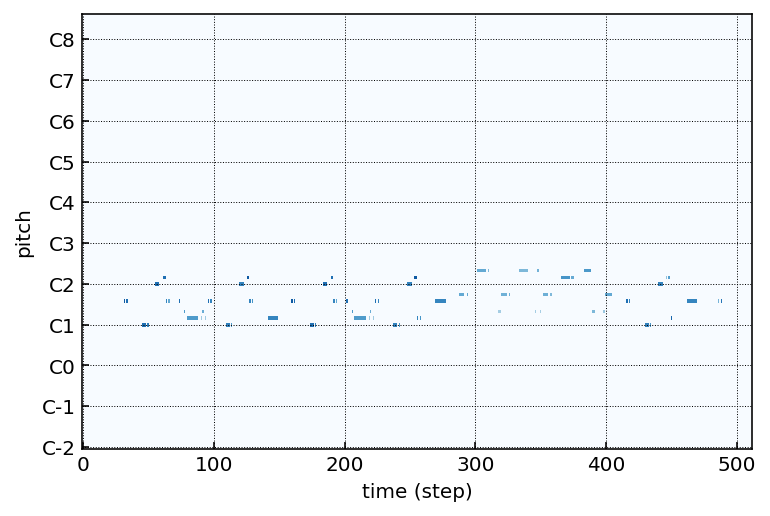

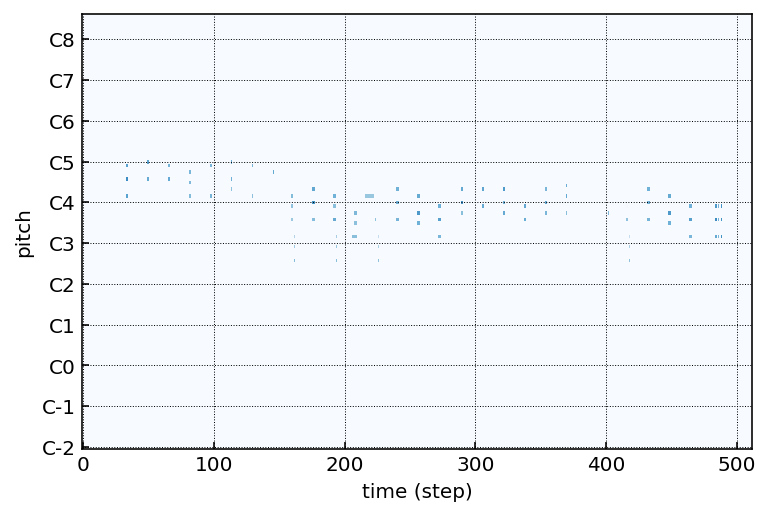

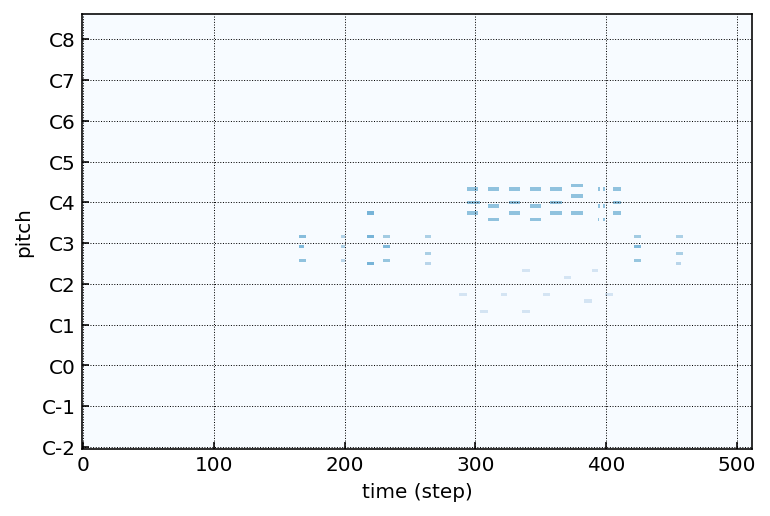

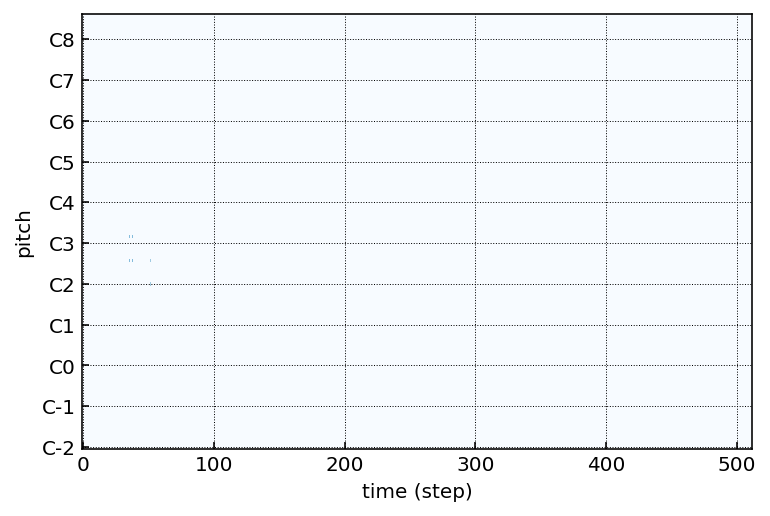

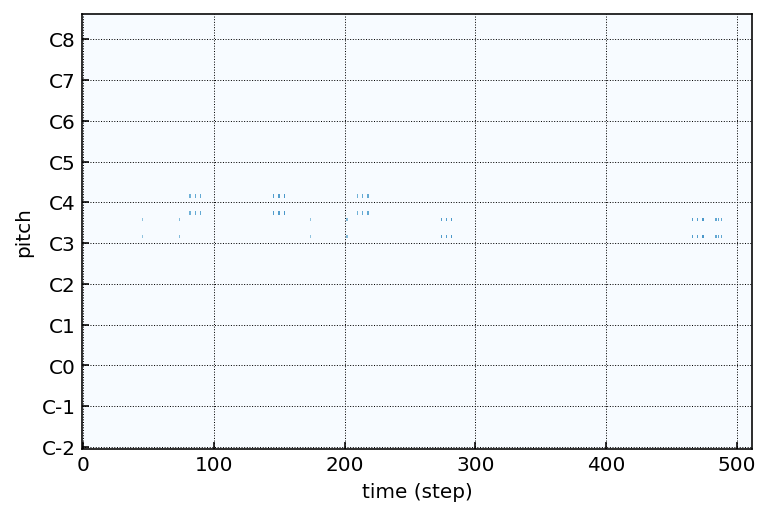

Successfully processed filename----> ./reggae_midi/REGGAE-1.mid
Starting to process filename----> ./reggae_midi/.ipynb_checkpoints


In [24]:
#holds final reshaped tracks that will be saved to training .npy file
track_list = np.empty(shape=(0,32,128,4))

#init with beat resolution of 4 
music_tracks = pypianoroll.Multitrack(beat_resolution=4) 

#loop through all the .mid files
for filename in os.listdir(reggae_midi_location):
    print("Starting to process filename---->", reggae_midi_location + filename)
    
    if filename.endswith(".mid"):
        try:
            #Load MIDI file using parse_midi
            #returns Multi-Track object containing Track objects
            music_tracks.parse_midi(reggae_midi_location + filename) 
            
            #add padding to avoid reshape errors
            #pad the pianorolls with zeros making the length a multiple of 32
            music_tracks.pad_to_multiple(32)
            music_tracks.pad_to_same()
            
            #merge pianoroll objects by instrument 
            merged_tracks_to_add_to_training_file = get_merged(music_tracks, filename)
    
            #concatenate merged pianoroll objects to final training data track list
            track_list = np.concatenate((merged_tracks_to_add_to_training_file, track_list))
            
            print("Successfully processed filename---->", reggae_midi_location + filename)
        except Exception as e:
            print("**********ERROR**************It's possible that not all 4 instruments exist in this track; at least one is 0")
            print("Skipping file---->", filename, e)
            print(e)
            
# binarize data
track_list[track_list == 0] = -1
track_list[track_list >= 0] = 1

#save the training data to reggae-train.npy
save(train_dir + '/reggae-train.npy', np.array(track_list)) 

# Review Training Data

Testing the training shape:  (1, 32, 128, 4)


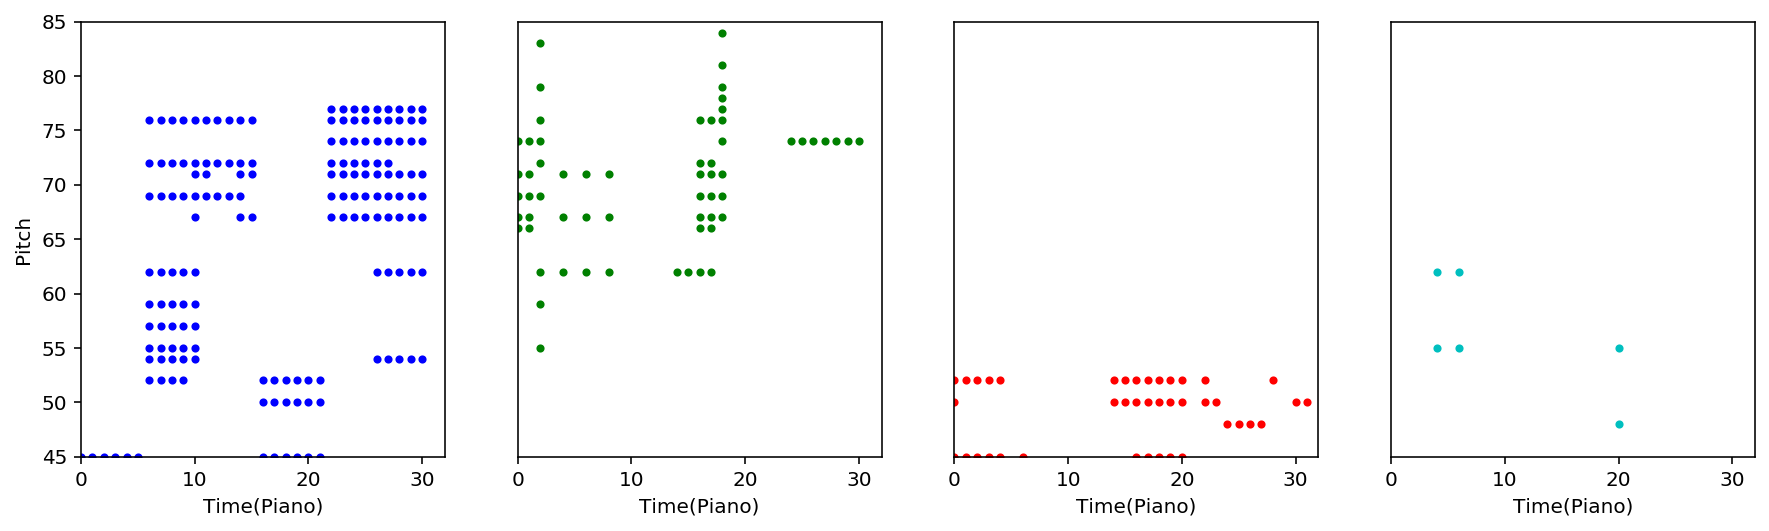

In [25]:
#double check the shape on training data, should be (x, 32, 128, 4), where x represents the amount of records
training_data = np.load(train_dir + '/reggae-train.npy')
print("Testing the training shape: ", training_data.shape)

#view sample of data that will be feed to model, four graphs == four tracks
display_utils.show_pianoroll(training_data)
